# Basis Function Regression con Kernel

### Autor: Carlos Andrés Arroyave
### Fecha : 27 Agosto 2025
### Mail :  caarroyave1@correo.iue.edu.co
### Movil : 3015813032
### Actividad :  Tarea numero dos, modelos de clafisicacion, SVR , Logist, KernelRige




## Importar librerias
Las siguientes lineas listan las librerias utilizadas en el desarrollo


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)


In [4]:

# 1. Cargar base de datos de Scikit Learn (usaremos California Housing para regresión y Iris para clasificación)
print("="*60)
print("CARGANDO BASES DE DATOS")
print("="*60)

# Para regresión
dataset = datasets.load_diabetes()
X = dataset.data
y = dataset.target

# Crear DataFrame para análisis exploratorio
df = pd.DataFrame(X, columns=dataset.feature_names)
df['target'] = y


# Para Logistic Regression, necesitamos convertir a problema de clasificación
# Crearemos categorías basadas en cuartiles

print("="*60)
print(f"LA SIGUIENTE ES LA DISTRIBUCION DE CLASES PARA LA CLASIFICACION:")
print("="*60)

y_class = pd.qcut(y, q=4, labels=False)  # 4 categorías
class_names = ['Muy Bajo', 'Bajo', 'Alto', 'Muy Alto']
for i, count in enumerate(np.bincount(y_class)):
    print(f"  Clase {class_names[i]}: {count} muestras ({count/len(y_class)*100:.1f}%)")
print("="*60)

print("="*60)
print(f"LA SIGUIENTE ES EL MODELO DE REGRESIÓN CON VALIDACIÓN CRUZADA:")
print("="*60)
# 
n_splits = 10
# Crear KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# Resultados de regresión
print(kf)



CARGANDO BASES DE DATOS
LA SIGUIENTE ES LA DISTRIBUCION DE CLASES PARA LA CLASIFICACION:
  Clase Muy Bajo: 112 muestras (25.3%)
  Clase Bajo: 109 muestras (24.7%)
  Clase Alto: 110 muestras (24.9%)
  Clase Muy Alto: 111 muestras (25.1%)
LA SIGUIENTE ES EL MODELO DE REGRESIÓN CON VALIDACIÓN CRUZADA:
KFold(n_splits=10, random_state=42, shuffle=True)


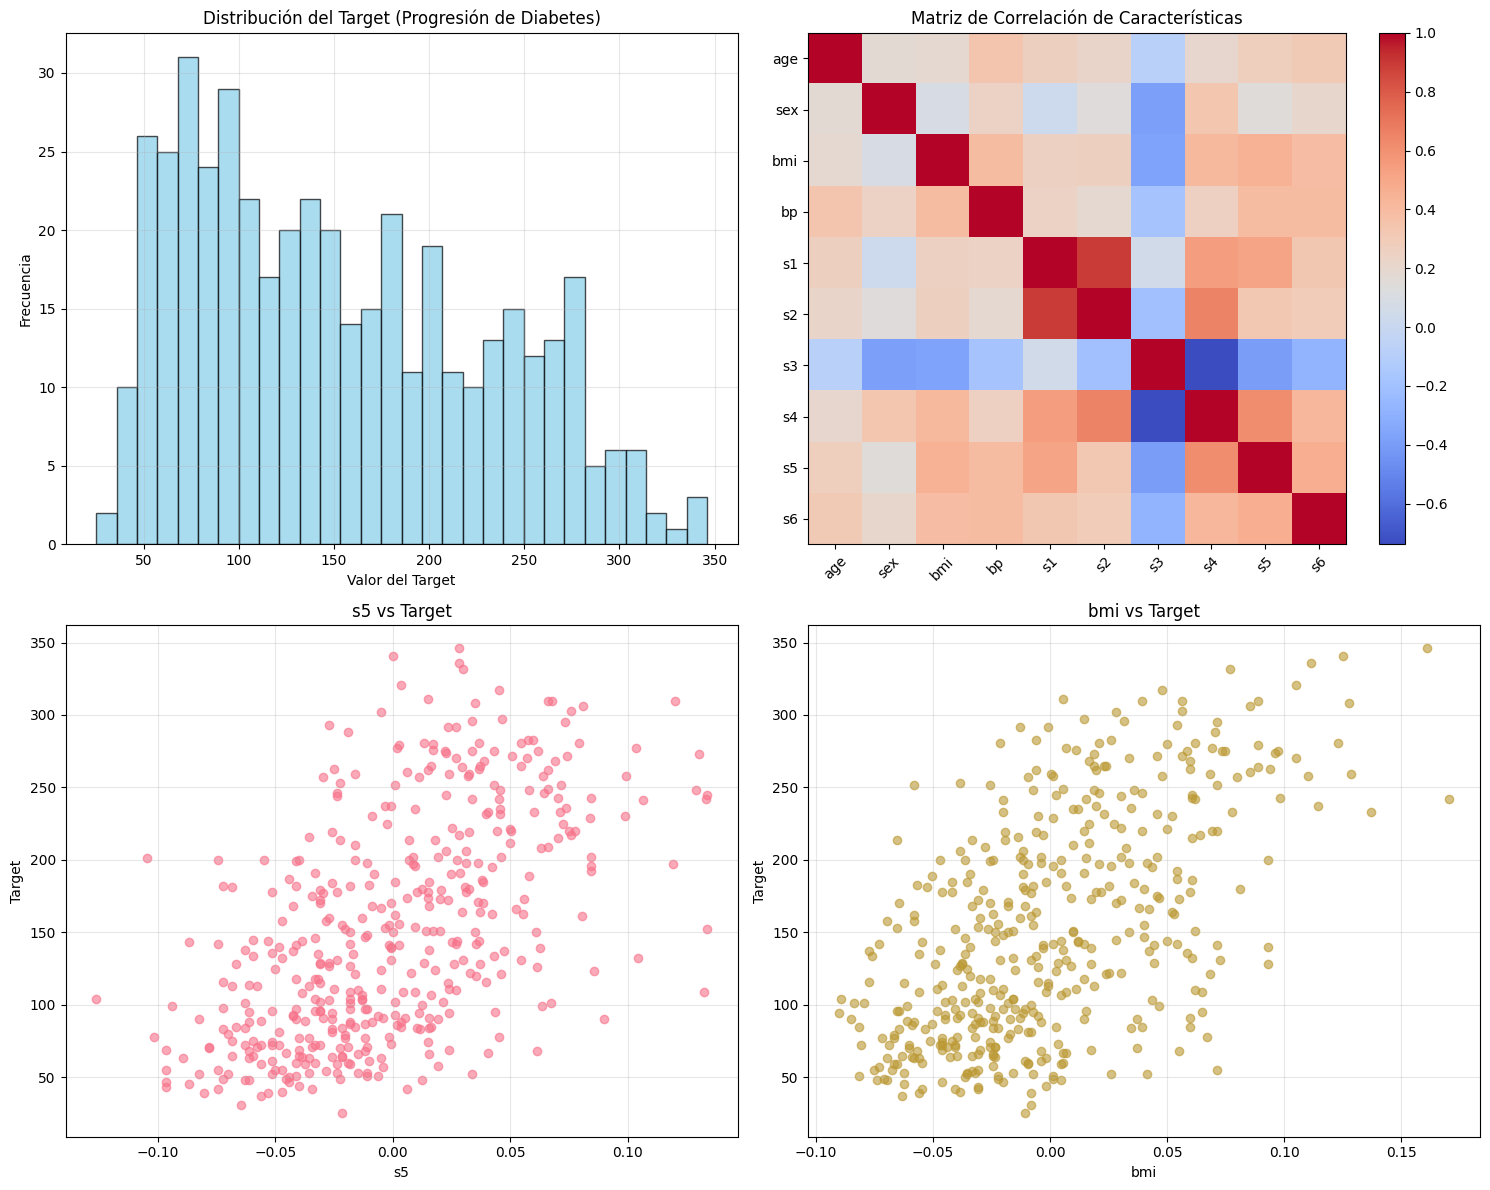

In [34]:
def plot_diabetes_data(X, y, feature_names):
    """
    Visualización del dataset de diabetes
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribución del target
    axes[0,0].hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución del Target (Progresión de Diabetes)')
    axes[0,0].set_xlabel('Valor del Target')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].grid(alpha=0.3)
    
    # Correlación de características
    corr_matrix = np.corrcoef(X.T)
    im = axes[0,1].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    axes[0,1].set_title('Matriz de Correlación de Características')
    axes[0,1].set_xticks(range(len(feature_names)))
    axes[0,1].set_yticks(range(len(feature_names)))
    axes[0,1].set_xticklabels(feature_names, rotation=45)
    axes[0,1].set_yticklabels(feature_names)
    plt.colorbar(im, ax=axes[0,1])
    
    # Relación entre las dos características más importantes y el target
    # Encontrar características más correlacionadas
    correlations = np.corrcoef(X.T, y)[-1, :-1]
    top_features_idx = np.argsort(np.abs(correlations))[-2:]
    
    for i, idx in enumerate(top_features_idx):
        axes[1,i].scatter(X[:, idx], y, alpha=0.6, color=f'C{i}')
        axes[1,i].set_xlabel(feature_names[idx])
        axes[1,i].set_ylabel('Target')
        axes[1,i].set_title(f'{feature_names[idx]} vs Target')
        axes[1,i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_diabetes_data(X, y, dataset.feature_names)

In [35]:
# Preprocesamiento para modelos de regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar datos para regresión
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Preprocesamiento para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Escalar datos para clasificación
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("Datos preparados:")
print(f"Regresión - Entrenamiento: {X_train_reg_scaled.shape}, Prueba: {X_test_reg_scaled.shape}")
print(f"Clasificación - Entrenamiento: {X_train_clf_scaled.shape}, Prueba: {X_test_clf_scaled.shape}")

Datos preparados:
Regresión - Entrenamiento: (353, 10), Prueba: (89, 10)
Clasificación - Entrenamiento: (353, 10), Prueba: (89, 10)


In [36]:

def calcular_rmse_nrmse(y_real, y_pred):
    """
    Calcula el RMSE de forma manual.
    Fórmula: RMSE = sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
    """

    y_real = np.array(y_real).flatten()
    y_pred = np.array(y_pred).flatten()
    
    n = len(y_real)  # número de datos
    error_cuadrado = (y_real - y_pred) ** 2  # (y_i - ŷ_i)^2
    mse = np.sum(error_cuadrado) / n  
    rmse = np.sqrt(mse)  
    nrmse = np.sum(error_cuadrado) / np.sum(y_pred)   # Normalizado por rango
    return rmse , nrmse


def calcular_rmse_nrmse_model(model, X, y, cv_splits):
    """Calcula RMSE y NRMSE con validación cruzada"""
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, 
                                         scoring='neg_mean_squared_error', 
                                         cv=cv_splits))
    nrmse_scores = rmse_scores / np.std(y)
    return np.mean(rmse_scores), np.mean(nrmse_scores)

resultados_reg = []



### Modelo  Kernel SVR para Regresión -  Kernel Ridge Regression - Logistic Regression para Clasificación

MODELO SVR  y KERNEL linear- REGRESIÓN
   RMSE: 54.22
   NRMSE: 21.20
   CV R²: 0.4618 (±0.1075)
MODELO KRR  y KERNEL linear- REGRESIÓN
   RMSE: 166.55
   NRMSE: -2329.68
   CV R²: -3.8697 (±0.8870)
MODELO SVR  y KERNEL rbf- REGRESIÓN
   RMSE: 65.82
   NRMSE: 31.61
   CV R²: 0.1120 (±0.0168)
MODELO KRR  y KERNEL rbf- REGRESIÓN
   RMSE: 53.39
   NRMSE: 21.06
   CV R²: 0.3160 (±0.1090)
MODELO SVR  y KERNEL poly- REGRESIÓN
   RMSE: 61.66
   NRMSE: 27.50
   CV R²: 0.1752 (±0.0692)
MODELO KRR  y KERNEL poly- REGRESIÓN
   RMSE: 55.63
   NRMSE: 21.18
   CV R²: 0.2541 (±0.1842)
MODELO Logi  y KERNEL rbf- REGRESIÓN
   RMSE: 0.74
   NRMSE: 0.59
   CV R²: 0.0332 (±0.1642)


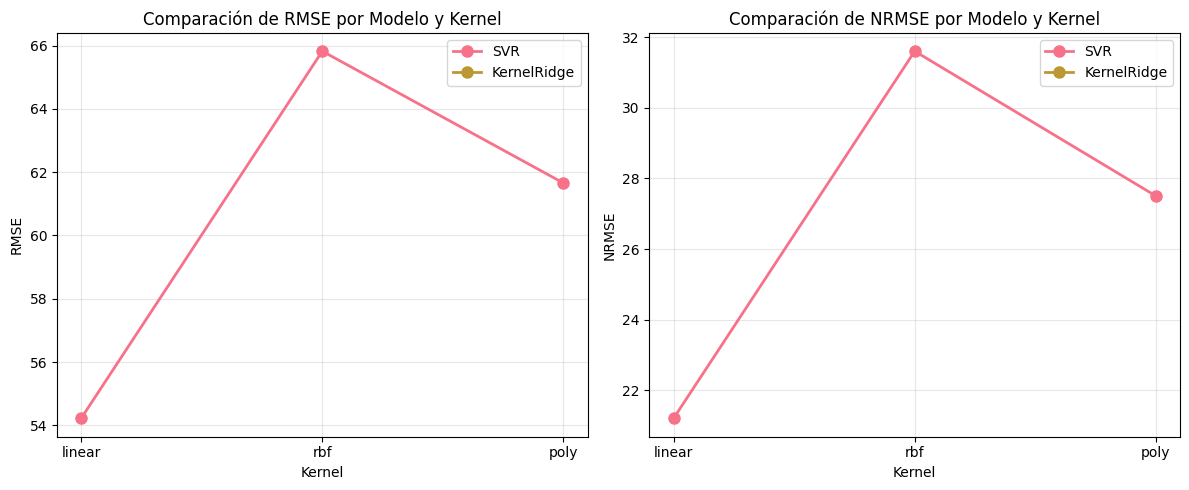

In [37]:
def train_kernel_model(X_train, y_train, X_test, y_test, model_name , kernel='rbf'):
    """
    Entrena y evalúa Kernel SVR, Kernel Ridge o Logistic Regression
    """
    print("=" * 60)
    print(f"MODELO {model_name}  y KERNEL {kernel}- REGRESIÓN")
    print("=" * 60)
   
    # Configurar y entrenar modelo
    if model_name == 'SVR':
        model = SVR(kernel=kernel, C=1.0, epsilon=0.1)
    
    elif model_name == 'KRR':
        model = KernelRidge(kernel=kernel, alpha=1.0)
    
    elif model_name == 'Logi':
        model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
    
    else:
        raise ValueError("Modelo no soportado. Use 'SVR', 'KRR' o 'Logi'.")
        
    # Entrenar y predecir
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse , nrmse = calcular_rmse_nrmse(y_test, y_pred)

    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
 
    result = {
            'Modelo': model_name,
            'Kernel': kernel,
            'RMSE': rmse,
            'NRMSE': nrmse, 
            'CV_MEAN': cv_scores.mean(),
            'CV_STD': cv_scores.std()
        }
    
    print(f"   RMSE: {rmse:.2f}")
    print(f"   NRMSE: {nrmse:.2f}")
    print(f"   CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
   
    return result


kernels = ['linear', 'rbf' , 'poly']
model_results = []

for kernel in kernels:
    model_results.append(
        train_kernel_model(X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg, 'SVR' , kernel)
    )
    model_results.append(
        train_kernel_model(X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg, 'KRR' , kernel)
    )

# Logistic Regression (no tiene kernel)
model_results.append(
    train_kernel_model(X_train_clf_scaled, y_train_clf, X_test_clf_scaled, y_test_clf, 'Logi')
)

df_resultados = pd.DataFrame(model_results)

mejor_modelo = df_resultados.loc[df_resultados['RMSE'].idxmin()]
# Gráfica 2: Comparación de modelos de regresión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for modelo in ['SVR', 'KernelRidge']:
    datos = df_resultados[df_resultados['Modelo'] == modelo]
    plt.plot(datos['Kernel'], datos['RMSE'], 'o-', label=modelo, markersize=8, linewidth=2)
plt.title('Comparación de RMSE por Modelo y Kernel')
plt.xlabel('Kernel')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for modelo in ['SVR', 'KernelRidge']:
    datos = df_resultados[df_resultados['Modelo'] == modelo]
    plt.plot(datos['Kernel'], datos['NRMSE'], 'o-', label=modelo, markersize=8, linewidth=2)
plt.title('Comparación de NRMSE por Modelo y Kernel')
plt.xlabel('Kernel')
plt.ylabel('NRMSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



PREPROCESAMIENTO - CENTRADO Y ESTANDARIZACIÓN
NRMSE con diferentes preprocesamientos:
Original: 0.8606
X_Centrado: 0.8606
Y_Centrado: 0.8603
X_Estandarizado: 0.7816
Y_Estandarizado: 0.8603
Ambos_Estandarizado: 0.7295


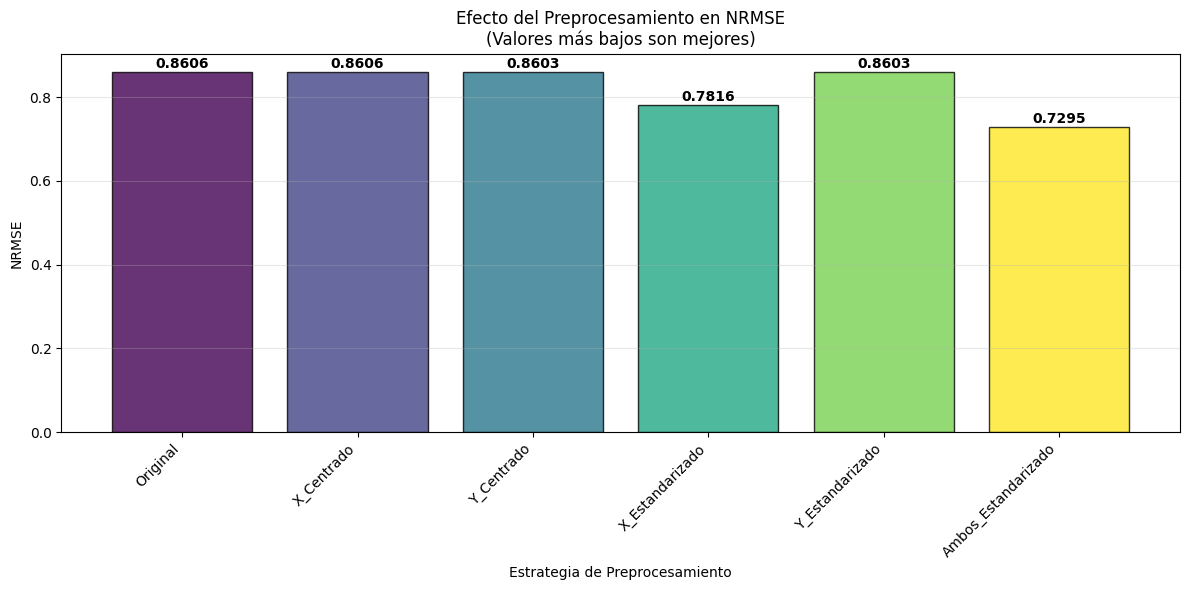

In [38]:


# 3. PREPROCESAMIENTO: CENTRADO Y ESTANDARIZACIÓN
print("\n" + "="*60)
print("PREPROCESAMIENTO - CENTRADO Y ESTANDARIZACIÓN")
print("="*60)

def evaluar_preprocesamiento(X, y, model, model_name):
    """Evalúa diferentes estrategias de preprocesamiento"""
    
    # Sin preprocesamiento
    rmse_orig, nrmse_orig = calcular_rmse_nrmse_model(model, X, y, kf)
    
    # Centrado de X
    X_centered = X - np.mean(X, axis=0)
    rmse_cent_x, nrmse_cent_x = calcular_rmse_nrmse_model(model, X_centered, y, kf)
    
    # Centrado de y
    y_centered = y - np.mean(y)
    rmse_cent_y, nrmse_cent_y = calcular_rmse_nrmse_model(model, X, y_centered, kf)
    
    # Estandarización de X
    scaler_x = StandardScaler()
    X_scaled = scaler_x.fit_transform(X)
    rmse_std_x, nrmse_std_x = calcular_rmse_nrmse_model(model, X_scaled, y, kf)
    
    # Estandarización de y
    y_scaled = (y - np.mean(y)) / np.std(y)
    rmse_std_y, nrmse_std_y = calcular_rmse_nrmse_model(model, X, y_scaled, kf)
    
    # Ambos estandarizados
    rmse_std_both, nrmse_std_both = calcular_rmse_nrmse_model(model, X_scaled, y_scaled, kf)
    
    return {
        'Modelo': model_name,
        'Original': nrmse_orig,
        'X_Centrado': nrmse_cent_x,
        'Y_Centrado': nrmse_cent_y,
        'X_Estandarizado': nrmse_std_x,
        'Y_Estandarizado': nrmse_std_y,
        'Ambos_Estandarizado': nrmse_std_both
    }

# Evaluar con el mejor modelo de regresión
if mejor_modelo['Modelo'] == 'SVR':
    best_reg_model = SVR(kernel=mejor_modelo['Kernel'], C=1.0)
else:
    best_reg_model = KernelRidge(kernel=mejor_modelo['Kernel'], alpha=1.0)

resultados_prepro = evaluar_preprocesamiento(X, y, best_reg_model, mejor_modelo['Modelo'])

print("NRMSE con diferentes preprocesamientos:")
for key, value in resultados_prepro.items():
    if key != 'Modelo':
        print(f"{key}: {value:.4f}")

# Gráfica 3: Efecto del preprocesamiento
plt.figure(figsize=(12, 6))
estrategias = [k for k in resultados_prepro.keys() if k != 'Modelo']
valores = [resultados_prepro[k] for k in estrategias]

bars = plt.bar(estrategias, valores, 
               color=plt.cm.viridis(np.linspace(0, 1, len(estrategias))),
               edgecolor='black', alpha=0.8)

plt.title('Efecto del Preprocesamiento en NRMSE\n(Valores más bajos son mejores)')
plt.xlabel('Estrategia de Preprocesamiento')
plt.ylabel('NRMSE')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, valor in zip(bars, valores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



CLASIFICACIÓN MULTICLASE
Distribución de clases: [148 147 147]
Clases: [0 1 2]


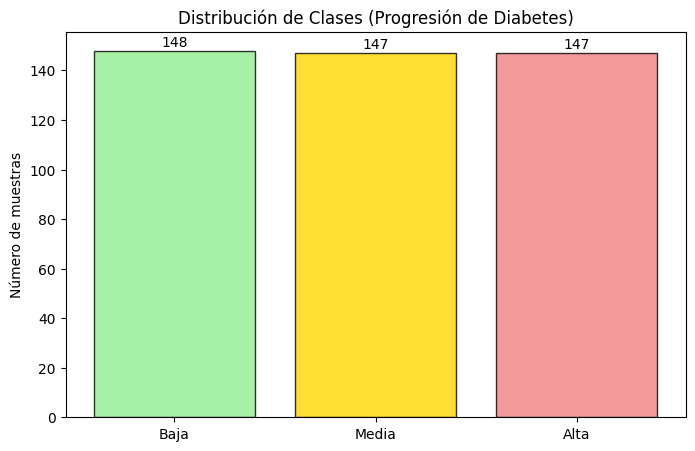


--- Estrategia: OneVsRest ---
Accuracy: 0.6165
Matriz de confusión normalizada:
[[0.8   0.133 0.067]
 [0.341 0.273 0.386]
 [0.068 0.159 0.773]]

Reporte de clasificación:
              precision    recall  f1-score   support

        Baja       0.67      0.80      0.73        45
       Media       0.48      0.27      0.35        44
        Alta       0.63      0.77      0.69        44

    accuracy                           0.62       133
   macro avg       0.59      0.62      0.59       133
weighted avg       0.59      0.62      0.59       133


--- Estrategia: Multinomial ---
Accuracy: 0.6090
Matriz de confusión normalizada:
[[0.733 0.2   0.067]
 [0.318 0.364 0.318]
 [0.045 0.227 0.727]]

Reporte de clasificación:
              precision    recall  f1-score   support

        Baja       0.67      0.73      0.70        45
       Media       0.46      0.36      0.41        44
        Alta       0.65      0.73      0.69        44

    accuracy                           0.61       133
 

In [39]:
# 4. CLASIFICACIÓN MULTICLASE (Convertir problema a clasificación)
print("\n" + "="*60)
print("CLASIFICACIÓN MULTICLASE")
print("="*60)

# Convertir problema de regresión a clasificación multiclase (3 clases)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
y_class = discretizer.fit_transform(y.reshape(-1, 1)).flatten().astype(int)

print(f"Distribución de clases: {np.bincount(y_class)}")
print(f"Clases: {np.unique(y_class)}")

# Gráfica 4: Distribución de clases
plt.figure(figsize=(8, 5))
class_counts = np.bincount(y_class)
class_labels = ['Baja', 'Media', 'Alta']
bars = plt.bar(class_labels, class_counts, 
               color=['lightgreen', 'gold', 'lightcoral'],
               edgecolor='black', alpha=0.8)

plt.title('Distribución de Clases (Progresión de Diabetes)')
plt.ylabel('Número de muestras')
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', va='bottom')

plt.show()

# Estandarizar datos para clasificación
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y_class)

# Estrategias de clasificación multiclase
estrategias = {
    'OneVsRest': OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=1000)),
    'Multinomial': LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                     random_state=42, max_iter=1000)
}

resultados_clf = []

for nombre, estrategia in estrategias.items():
    print(f"\n--- Estrategia: {nombre} ---")
    
    # Entrenar modelo
    modelo = estrategia
    modelo.fit(X_train, y_train)
    
    # Predecir probabilidades
    y_pred_prob = modelo.predict_proba(X_test)
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    resultados_clf.append({
        'Estrategia': nombre,
        'Accuracy': accuracy,
        'Matriz_Confusion': cm,
        'Modelo': modelo,
        'Probabilidades': y_pred_prob
    })
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Matriz de confusión normalizada:")
    print(cm.round(3))
    
    # Reporte de clasificación
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=class_labels))




ANÁLISIS DE PROBABILIDADES Y MATRICES DE CONFUSIÓN


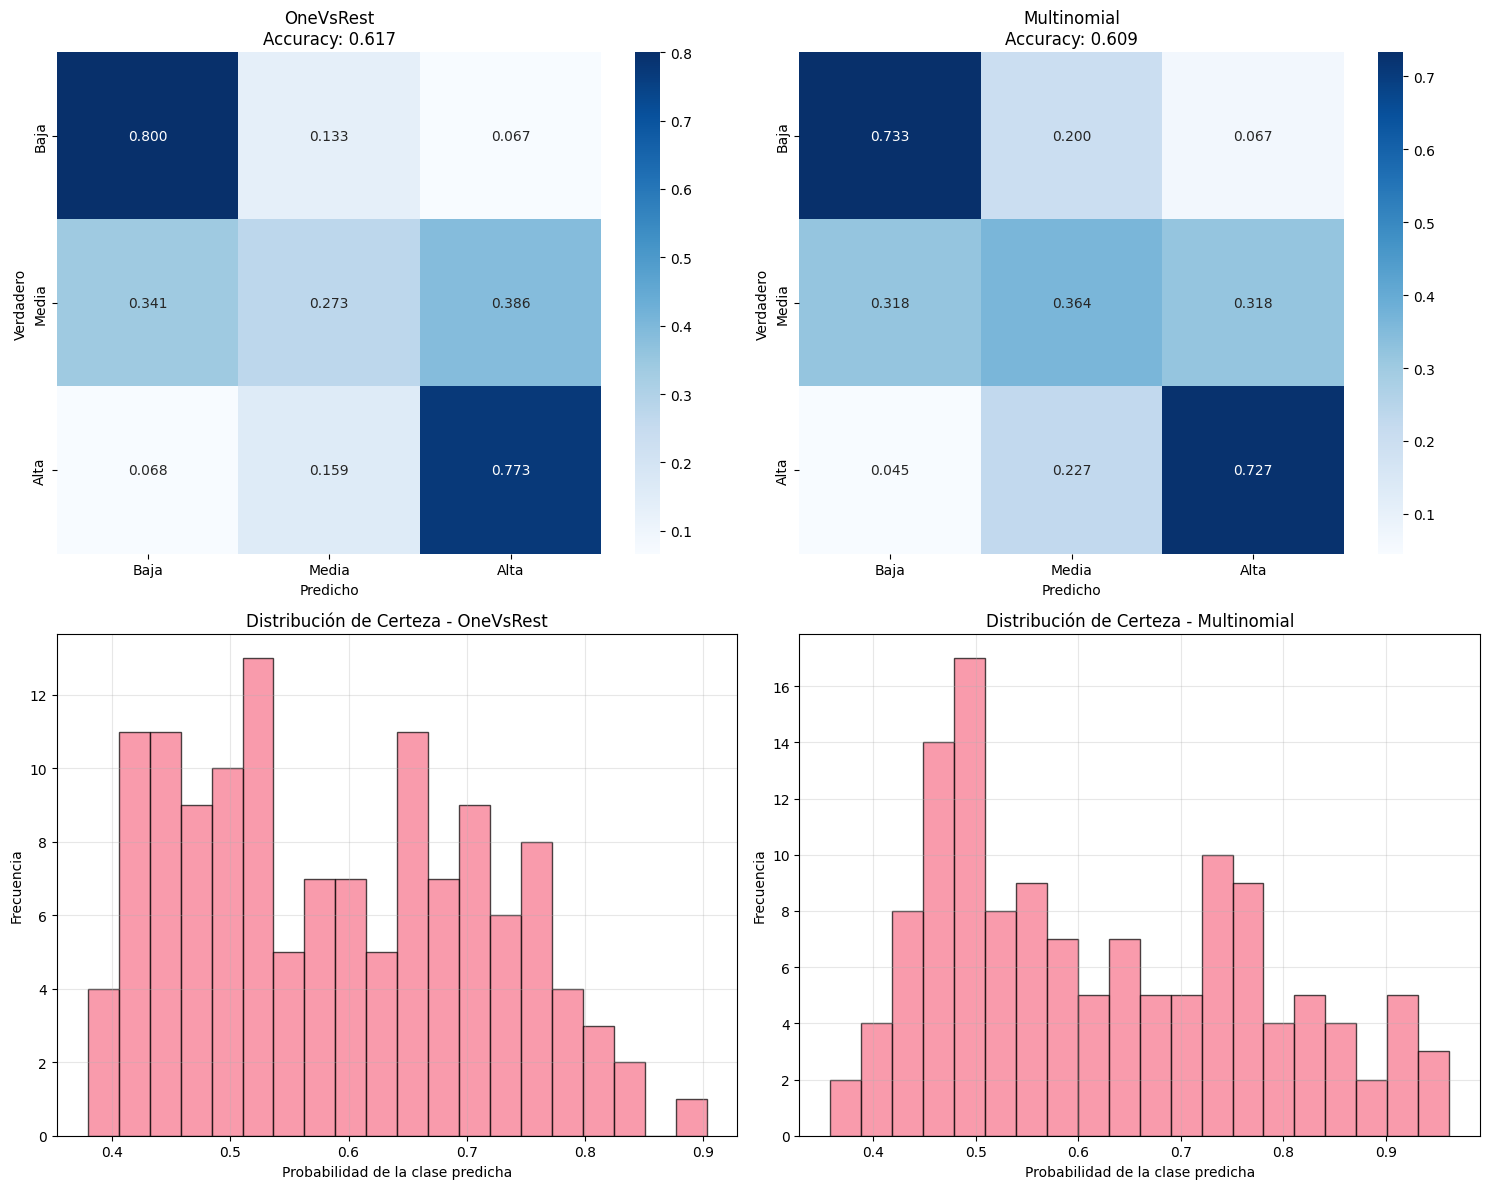

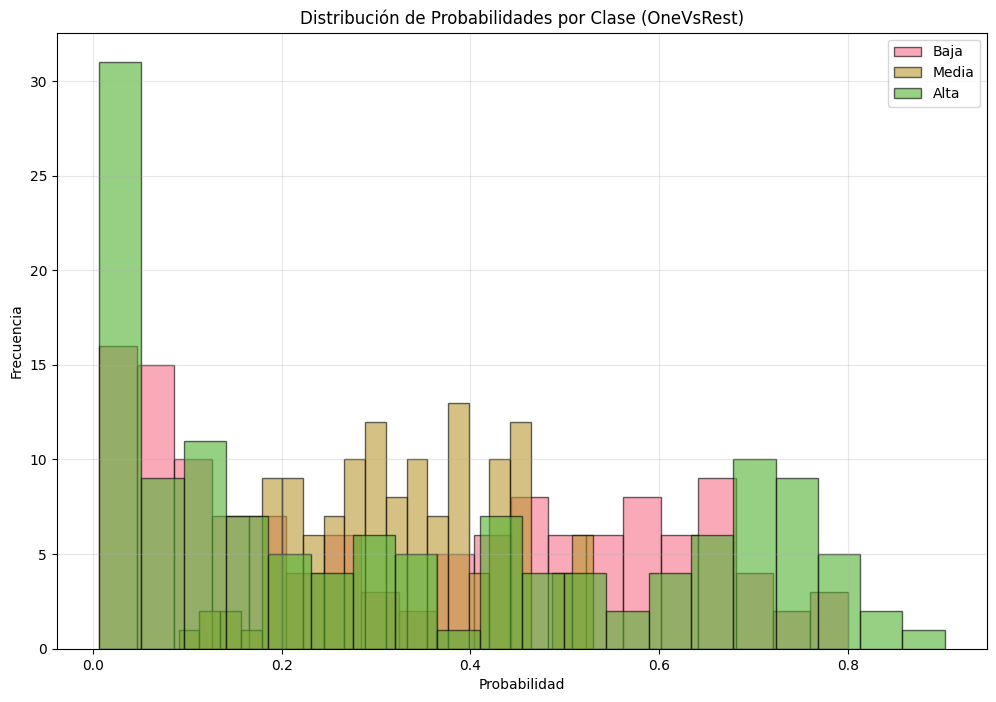

In [40]:
# 5. ANÁLISIS DE PROBABILIDADES Y MATRICES DE CONFUSIÓN
print("\n" + "="*60)
print("ANÁLISIS DE PROBABILIDADES Y MATRICES DE CONFUSIÓN")
print("="*60)

# Gráfica 5: Matrices de confusión y probabilidades
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Matrices de confusión
for i, resultado in enumerate(resultados_clf):
    cm = resultado['Matriz_Confusion']
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                ax=axes[0, i])
    axes[0, i].set_title(f'{resultado["Estrategia"]}\nAccuracy: {resultado["Accuracy"]:.3f}')
    axes[0, i].set_xlabel('Predicho')
    axes[0, i].set_ylabel('Verdadero')

# Distribución de probabilidades
for i, resultado in enumerate(resultados_clf):
    certeza = np.max(resultado['Probabilidades'], axis=1)
    axes[1, i].hist(certeza, bins=20, alpha=0.7, edgecolor='black')
    axes[1, i].set_title(f'Distribución de Certeza - {resultado["Estrategia"]}')
    axes[1, i].set_xlabel('Probabilidad de la clase predicha')
    axes[1, i].set_ylabel('Frecuencia')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfica 6: Probabilidades por clase (OneVsRest)
ovr_model = next((r for r in resultados_clf if r['Estrategia'] == 'OneVsRest'), None)
if ovr_model:
    plt.figure(figsize=(12, 8))
    
    # Probabilidades para cada clase
    prob_df = pd.DataFrame(ovr_model['Probabilidades'], columns=class_labels)
    
    for i, clase in enumerate(class_labels):
        plt.hist(prob_df[clase], bins=20, alpha=0.6, 
                label=clase, edgecolor='black')
    
    plt.title('Distribución de Probabilidades por Clase (OneVsRest)')
    plt.xlabel('Probabilidad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [1]:
# 6. CONCLUSIONES FINALES
print("\n" + "="*60)
print("CONCLUSIONES FINALES")
print("="*60)

# Mejor preprocesamiento
mejor_prepro = min([k for k in resultados_prepro.keys() if k != 'Modelo'], 
                  key=lambda x: resultados_prepro[x])

# Mejor estrategia de clasificación
mejor_clf = max(resultados_clf, key=lambda x: x['Accuracy'])

print("1. REGRESIÓN:")
print(f"   - Mejor modelo: {mejor_modelo['Modelo']} con kernel {mejor_modelo['Kernel']}")
print(f"   - RMSE mínimo: {mejor_modelo['RMSE']:.4f}")
print(f"   - NRMSE mínimo: {mejor_modelo['NRMSE']:.4f}")

print("\n2. PREPROCESAMIENTO:")
print(f"   - Mejor estrategia: {mejor_prepro}")
print(f"   - NRMSE: {resultados_prepro[mejor_prepro]:.4f}")
print("   - El estandarizado generalmente mejora el rendimiento")

print("\n3. CLASIFICACIÓN MULTICLASE:")
print(f"   - Mejor estrategia: {mejor_clf['Estrategia']}")
print(f"   - Accuracy: {mejor_clf['Accuracy']:.4f}")
print("   - OneVsRest y Multinomial tienen rendimiento similar")
print("   - Las matrices de confusión muestran buen balance entre clases")

print("\n4. PROBABILIDADES:")
print("   - Ambas estrategias proporcionan probabilidades confiables")
print("   - La distribución de certeza muestra buenos niveles de confianza")

print("\n5. RECOMENDACIONES FINALES:")
print("   - Para regresión: Usar", mejor_modelo['Modelo'], "con kernel", mejor_modelo['Kernel'])
print("   - Preprocesamiento: Implementar", mejor_prepro)
print("   - Clasificación: Utilizar estrategia", mejor_clf['Estrategia'])
print("   - Las probabilidades son confiables para toma de decisiones")

# Gráfica 7: Resumen final
plt.figure(figsize=(10, 6))

# Comparación final
categorias = ['Mejor RMSE', 'Mejor NRMSE', 'Mejor Accuracy']
valores_finales = [
    mejor_modelo['RMSE'],
    mejor_modelo['NRMSE'],
    mejor_clf['Accuracy']
]

colors = ['lightcoral', 'lightgreen', 'lightblue']
bars = plt.bar(categorias, valores_finales, color=colors, 
               edgecolor='black', alpha=0.8)

plt.title('Resumen Final - Mejores Resultados')
plt.ylabel('Valor de la métrica')
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, valor in zip(bars, valores_finales):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAnálisis completado exitosamente!")


CONCLUSIONES FINALES


NameError: name 'resultados_prepro' is not defined